# General models

Aim to create a range of underfitting, overfitting and fairly well optimised models based on bitcoin dataset.

These models will help give some indication of the effects of adding and removing parameters and hyperparameters and serve as a set of baseline models to work from when optimising each coin for the most effective sets of parameters found.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import numpy as np
from helper_functions import *
from datetime import date, timedelta
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop


#Importing the dataset and inspection
current_folder = os.path.abspath('')
bitcoin_csv = os.path.join(current_folder, "data","bitcoin_hourly.csv")
bitcoin_df = pd.read_csv(bitcoin_csv)

# Adding a difference high low as a possible feature to use
# in place of providing high and low seperately
bitcoin_df['highLowDif'] = bitcoin_df['highPriceUsd'] - bitcoin_df['lowPriceUsd']

# converting datetime to datetime format (from stroing) for easierr filtering
bitcoin_df['datetime'] = pd.to_datetime(bitcoin_df['datetime'], errors='coerce')

# filtering dates to a hundred days from collection start
start_point = bitcoin_df['datetime'][0]
end_point = start_point + timedelta(100)

filter_dates = bitcoin_df['datetime'] >= pd.to_datetime(start_point)
timeperiod_df = bitcoin_df[filter_dates]
filter_dates = timeperiod_df['datetime'] < pd.to_datetime(end_point)
timeperiod_df = timeperiod_df[filter_dates]

In [2]:
# double checking there are no nan values in the timeperiod
print(rows_with_nan_values(timeperiod_df))

[]


In [3]:
bitcoin_df.iloc[0]

datetime                      2021-02-03 00:00:00+00:00
bitcoin_count                                      1557
bitcoin_polarity                               0.198884
bitcoin_subjectivity                           0.503805
bitcoin_polarity_zeros                         0.105064
bitcoin_subjectivity_zeros                     0.303084
openPriceUsd                                    35510.8
closePriceUsd                                   36119.5
highPriceUsd                                    36131.9
lowPriceUsd                                       35444
volume                                      62260118369
marketcap                                  672459334169
highLowDif                                      687.926
Name: 0, dtype: object

In [4]:
timeperiod_df = timeperiod_df.drop(columns=['datetime', 'bitcoin_polarity', 'bitcoin_subjectivity', 'openPriceUsd',  'marketcap', 'highLowDif'])

In [5]:
timeperiod_df.iloc[0]

bitcoin_count                 1.557000e+03
bitcoin_polarity_zeros        1.050641e-01
bitcoin_subjectivity_zeros    3.030843e-01
closePriceUsd                 3.611949e+04
highPriceUsd                  3.613191e+04
lowPriceUsd                   3.544398e+04
volume                        6.226012e+10
Name: 0, dtype: float64

In [6]:
# setting the training, validation, test split
# there are 2400 samples in the 100 day timeperiod
training_samples = int(len(timeperiod_df) * 0.7) # 1680
validation_samples = int(len(timeperiod_df) * 0.2) # 480
test_samples = int(len(timeperiod_df) * 0.1) # 240

# normalising the data
timeperiod_df = normalise_data(timeperiod_df, training_samples, validation_samples)

# returning factors used to normalise the data (in order to reverse)
mean, std = normalisation_values(timeperiod_df, training_samples, validation_samples)

# setting up sequence batches, how far back is looked and how far forward predictions are made
lookback = 120      # 120 / 24 = 5 days
step = 1            # 1hr step
delay = 24          # predictions 1 day in 'future'
batch_size = 128    

# creating the datasets of batches 
# (note due to) small size of test_dataset and te way the keras method to create timeseries datasets works, it is empty we will remake it
train_dataset, val_dataset, test_dataset = create_datasets(timeperiod_df, 'closePriceUsd', training_samples, validation_samples, lookback, step, delay, batch_size)

#clearing the test dataset
test_dataset = None

# getting the shape of the datasets to pass into model parameters
shape_1, shape_2 = get_dataset_shape(train_dataset)

final sample - training: 1680th, validation: 2160th, test: 2400th
Input shape: (128, 120, 7)
Target shape: (128, 1)


Epoch 1/20
13/13 [==============================] - 5s 258ms/step - loss: 1.3889 - val_loss: 0.5161
Epoch 2/20
13/13 [==============================] - 3s 231ms/step - loss: 0.2125 - val_loss: 0.3436
Epoch 3/20
13/13 [==============================] - 3s 235ms/step - loss: 0.2100 - val_loss: 0.4593
Epoch 4/20
13/13 [==============================] - 3s 231ms/step - loss: 0.1857 - val_loss: 0.5617
Epoch 5/20
13/13 [==============================] - 3s 228ms/step - loss: 0.1938 - val_loss: 0.4659
Epoch 6/20
13/13 [==============================] - 3s 231ms/step - loss: 0.1820 - val_loss: 0.9180
Epoch 7/20
13/13 [==============================] - 3s 235ms/step - loss: 0.2288 - val_loss: 0.5687
Epoch 8/20
13/13 [==============================] - 4s 282ms/step - loss: 0.1987 - val_loss: 0.5075
Epoch 9/20
13/13 [==============================] - 3s 241ms/step - loss: 0.1562 - val_loss: 0.5922
Epoch 10/20
13/13 [==============================] - 3s 228ms/step - loss: 0.1960 - val_loss: 0.6443

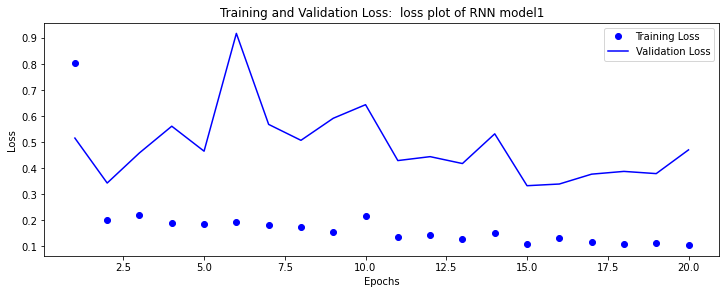

In [7]:
RNN_model1 = models.Sequential()
RNN_model1.add(layers.SimpleRNN(100, return_sequences=True, input_shape=(shape_1, shape_2)))

RNN_model1.add(layers.SimpleRNN(100))


RNN_model1.add(layers.Dense(1))

RNN_model1.compile(optimizer=RMSprop(), loss='mse')
RNN_model1_history = RNN_model1.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(RNN_model1_history, "loss plot of RNN model1")

Epoch 1/20
13/13 [==============================] - 6s 313ms/step - loss: 1.2029 - val_loss: 2.3496
Epoch 2/20
13/13 [==============================] - 4s 325ms/step - loss: 0.4053 - val_loss: 1.2078
Epoch 3/20
13/13 [==============================] - 4s 279ms/step - loss: 0.2904 - val_loss: 1.4595
Epoch 4/20
13/13 [==============================] - 4s 285ms/step - loss: 0.2891 - val_loss: 0.9445
Epoch 5/20
13/13 [==============================] - 4s 263ms/step - loss: 0.2585 - val_loss: 0.7310
Epoch 6/20
13/13 [==============================] - 3s 261ms/step - loss: 0.2145 - val_loss: 1.1132
Epoch 7/20
13/13 [==============================] - 3s 259ms/step - loss: 0.2234 - val_loss: 1.0043
Epoch 8/20
13/13 [==============================] - 3s 255ms/step - loss: 0.2296 - val_loss: 0.7791
Epoch 9/20
13/13 [==============================] - 4s 340ms/step - loss: 0.2032 - val_loss: 0.6969
Epoch 10/20
13/13 [==============================] - 4s 271ms/step - loss: 0.1973 - val_loss: 0.5852

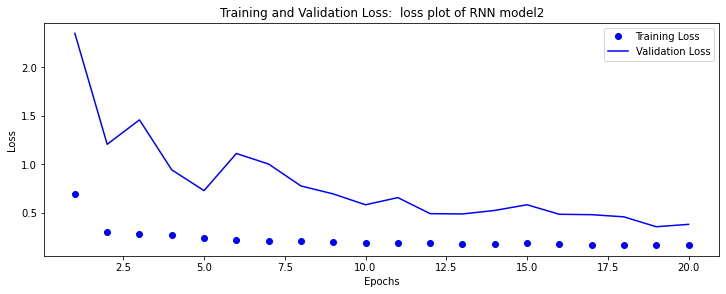

In [8]:
RNN_model2 = models.Sequential()
RNN_model2.add(layers.SimpleRNN(100, return_sequences=True,dropout=0.2, recurrent_dropout=0.2,input_shape=(shape_1, shape_2)))

RNN_model2.add(layers.SimpleRNN(100))


RNN_model2.add(layers.Dense(1))

RNN_model2.compile(optimizer=RMSprop(), loss='mse')
RNN_model2_history = RNN_model2.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(RNN_model2_history, "loss plot of RNN model2")

Epoch 1/30
13/13 [==============================] - 4s 219ms/step - loss: 1.1340 - val_loss: 0.8284
Epoch 2/30
13/13 [==============================] - 3s 198ms/step - loss: 0.2659 - val_loss: 0.7788
Epoch 3/30
13/13 [==============================] - 2s 187ms/step - loss: 0.2461 - val_loss: 0.6752
Epoch 4/30
13/13 [==============================] - 3s 235ms/step - loss: 0.2139 - val_loss: 0.5871
Epoch 5/30
13/13 [==============================] - 2s 185ms/step - loss: 0.1856 - val_loss: 0.5301
Epoch 6/30
13/13 [==============================] - 2s 193ms/step - loss: 0.1679 - val_loss: 0.6364
Epoch 7/30
13/13 [==============================] - 2s 187ms/step - loss: 0.1612 - val_loss: 0.4995
Epoch 8/30
13/13 [==============================] - 2s 189ms/step - loss: 0.1507 - val_loss: 0.5256
Epoch 9/30
13/13 [==============================] - 2s 177ms/step - loss: 0.1499 - val_loss: 0.5031
Epoch 10/30
13/13 [==============================] - 3s 202ms/step - loss: 0.1306 - val_loss: 0.3959

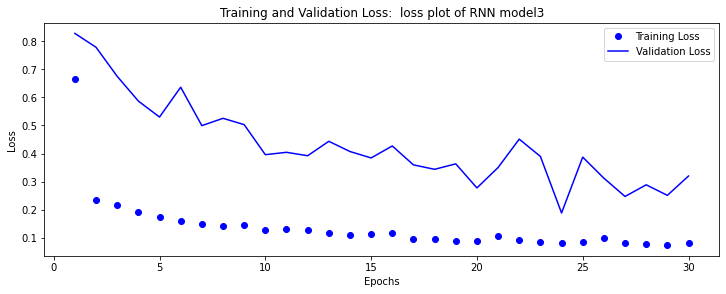

In [9]:
RNN_model3 = models.Sequential()
RNN_model3.add(layers.SimpleRNN(100, return_sequences=True, input_shape=(shape_1, shape_2)))

RNN_model3.add(layers.SimpleRNN(50))


RNN_model3.add(layers.Dense(1))

RNN_model3.compile(optimizer=RMSprop(), loss='mse')
RNN_model3_history = RNN_model3.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(RNN_model3_history, "loss plot of RNN model3")

Epoch 1/30
13/13 [==============================] - 4s 233ms/step - loss: 0.7109 - val_loss: 0.8496
Epoch 2/30
13/13 [==============================] - 3s 218ms/step - loss: 0.3499 - val_loss: 1.1251
Epoch 3/30
13/13 [==============================] - 3s 211ms/step - loss: 0.2870 - val_loss: 1.0696
Epoch 4/30
13/13 [==============================] - 3s 205ms/step - loss: 0.2649 - val_loss: 0.9246
Epoch 5/30
13/13 [==============================] - 3s 256ms/step - loss: 0.2490 - val_loss: 1.0244
Epoch 6/30
13/13 [==============================] - 3s 233ms/step - loss: 0.2371 - val_loss: 0.8602
Epoch 7/30
13/13 [==============================] - 3s 200ms/step - loss: 0.2058 - val_loss: 0.9995
Epoch 8/30
13/13 [==============================] - 3s 218ms/step - loss: 0.2156 - val_loss: 0.7782
Epoch 9/30
13/13 [==============================] - 3s 223ms/step - loss: 0.1931 - val_loss: 0.6693
Epoch 10/30
13/13 [==============================] - 3s 259ms/step - loss: 0.1899 - val_loss: 0.5867

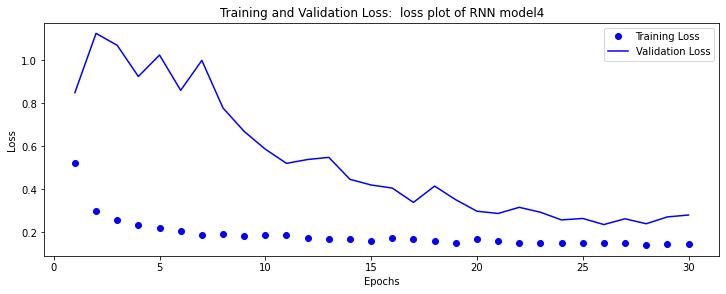

In [10]:
RNN_model4 = models.Sequential()
RNN_model4.add(layers.SimpleRNN(100, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

RNN_model4.add(layers.SimpleRNN(50))


RNN_model4.add(layers.Dense(1))

RNN_model4.compile(optimizer=RMSprop(), loss='mse')
RNN_model4_history = RNN_model4.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(RNN_model4_history, "loss plot of RNN model4")

Epoch 1/30
13/13 [==============================] - 3s 175ms/step - loss: 0.5932 - val_loss: 0.5433
Epoch 2/30
13/13 [==============================] - 2s 133ms/step - loss: 0.2274 - val_loss: 0.3778
Epoch 3/30
13/13 [==============================] - 2s 146ms/step - loss: 0.1847 - val_loss: 0.3725
Epoch 4/30
13/13 [==============================] - 2s 147ms/step - loss: 0.1788 - val_loss: 0.3345
Epoch 5/30
13/13 [==============================] - 2s 134ms/step - loss: 0.1704 - val_loss: 0.3220
Epoch 6/30
13/13 [==============================] - 2s 132ms/step - loss: 0.1697 - val_loss: 0.2815
Epoch 7/30
13/13 [==============================] - 2s 128ms/step - loss: 0.1440 - val_loss: 0.2311
Epoch 8/30
13/13 [==============================] - 2s 141ms/step - loss: 0.1482 - val_loss: 0.2439
Epoch 9/30
13/13 [==============================] - 2s 150ms/step - loss: 0.1480 - val_loss: 0.2919
Epoch 10/30
13/13 [==============================] - 2s 144ms/step - loss: 0.1503 - val_loss: 0.2309

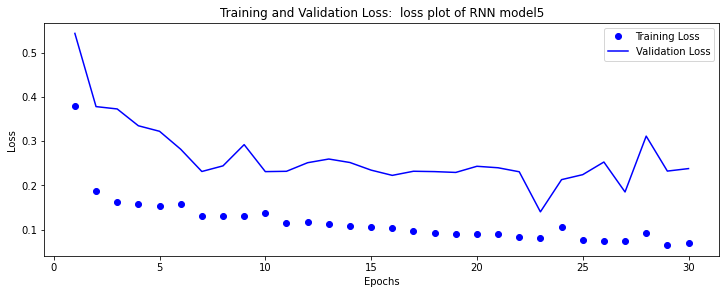

In [11]:
RNN_model5 = models.Sequential()
RNN_model5.add(layers.SimpleRNN(50, return_sequences=True, input_shape=(shape_1, shape_2)))

RNN_model5.add(layers.SimpleRNN(50))


RNN_model5.add(layers.Dense(1))

RNN_model5.compile(optimizer=RMSprop(), loss='mse')
RNN_model5_history = RNN_model5.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(RNN_model5_history, "loss plot of RNN model5")

Epoch 1/30
13/13 [==============================] - 4s 191ms/step - loss: 0.7480 - val_loss: 1.2844
Epoch 2/30
13/13 [==============================] - 2s 186ms/step - loss: 0.3558 - val_loss: 0.9831
Epoch 3/30
13/13 [==============================] - 2s 172ms/step - loss: 0.2739 - val_loss: 0.9674
Epoch 4/30
13/13 [==============================] - 2s 165ms/step - loss: 0.2575 - val_loss: 0.8944
Epoch 5/30
13/13 [==============================] - 2s 168ms/step - loss: 0.2368 - val_loss: 0.7970
Epoch 6/30
13/13 [==============================] - 2s 176ms/step - loss: 0.2122 - val_loss: 0.6536
Epoch 7/30
13/13 [==============================] - 2s 165ms/step - loss: 0.1952 - val_loss: 0.6402
Epoch 8/30
13/13 [==============================] - 2s 166ms/step - loss: 0.1931 - val_loss: 0.6830
Epoch 9/30
13/13 [==============================] - 2s 170ms/step - loss: 0.1885 - val_loss: 0.5853
Epoch 10/30
13/13 [==============================] - 2s 172ms/step - loss: 0.1805 - val_loss: 0.5051

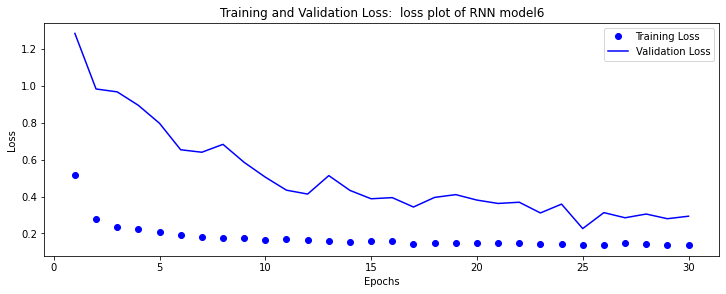

In [12]:
RNN_model6 = models.Sequential()
RNN_model6.add(layers.SimpleRNN(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

RNN_model6.add(layers.SimpleRNN(50))


RNN_model6.add(layers.Dense(1))

RNN_model6.compile(optimizer=RMSprop(), loss='mse')
RNN_model6_history = RNN_model6.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(RNN_model6_history, "loss plot of RNN model6")

Epoch 1/40
13/13 [==============================] - 4s 173ms/step - loss: 0.3034 - val_loss: 0.5906
Epoch 2/40
13/13 [==============================] - 3s 245ms/step - loss: 0.2084 - val_loss: 0.4520
Epoch 3/40
13/13 [==============================] - 2s 140ms/step - loss: 0.1733 - val_loss: 0.4088
Epoch 4/40
13/13 [==============================] - 2s 188ms/step - loss: 0.1660 - val_loss: 0.3798
Epoch 5/40
13/13 [==============================] - 2s 122ms/step - loss: 0.1604 - val_loss: 0.3576
Epoch 6/40
13/13 [==============================] - 2s 121ms/step - loss: 0.1558 - val_loss: 0.3380
Epoch 7/40
13/13 [==============================] - 2s 130ms/step - loss: 0.1518 - val_loss: 0.3197
Epoch 8/40
13/13 [==============================] - 2s 136ms/step - loss: 0.1483 - val_loss: 0.3030
Epoch 9/40
13/13 [==============================] - 2s 135ms/step - loss: 0.1450 - val_loss: 0.2883
Epoch 10/40
13/13 [==============================] - 2s 135ms/step - loss: 0.1417 - val_loss: 0.2758

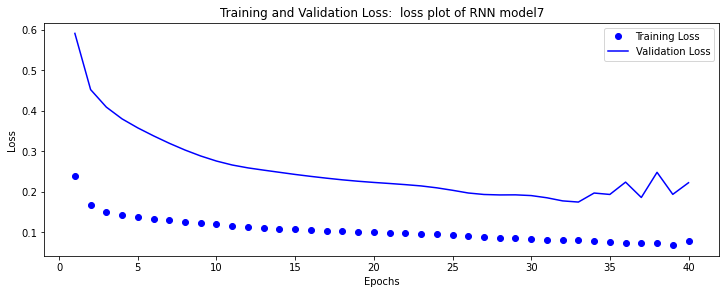

In [13]:
RNN_model7 = models.Sequential()
RNN_model7.add(layers.SimpleRNN(32, return_sequences=True, input_shape=(shape_1, shape_2)))

RNN_model7.add(layers.SimpleRNN(32))


RNN_model7.add(layers.Dense(1))

RNN_model7.compile(optimizer=RMSprop(), loss='mse')
RNN_model7_history = RNN_model7.fit(train_dataset, epochs=40, validation_data=val_dataset)

plot_simple_loss(RNN_model7_history, "loss plot of RNN model7")

Epoch 1/30
13/13 [==============================] - 4s 168ms/step - loss: 0.7371 - val_loss: 0.6256
Epoch 2/30
13/13 [==============================] - 2s 151ms/step - loss: 0.3620 - val_loss: 0.6056
Epoch 3/30
13/13 [==============================] - 2s 151ms/step - loss: 0.2787 - val_loss: 0.6039
Epoch 4/30
13/13 [==============================] - 2s 147ms/step - loss: 0.2570 - val_loss: 0.6016
Epoch 5/30
13/13 [==============================] - 2s 148ms/step - loss: 0.2400 - val_loss: 0.5303
Epoch 6/30
13/13 [==============================] - 2s 151ms/step - loss: 0.2159 - val_loss: 0.4972
Epoch 7/30
13/13 [==============================] - 2s 150ms/step - loss: 0.2132 - val_loss: 0.5176
Epoch 8/30
13/13 [==============================] - 2s 142ms/step - loss: 0.1838 - val_loss: 0.4748
Epoch 9/30
13/13 [==============================] - 2s 155ms/step - loss: 0.1964 - val_loss: 0.4057
Epoch 10/30
13/13 [==============================] - 2s 151ms/step - loss: 0.1775 - val_loss: 0.4217

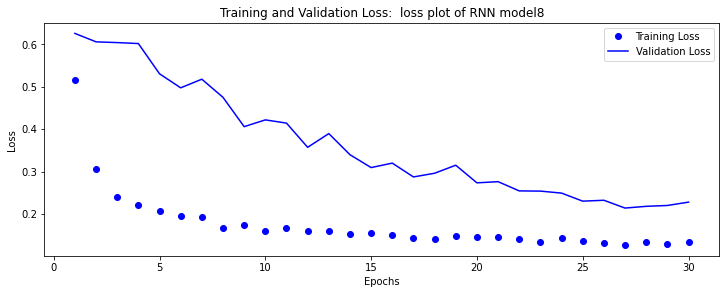

In [14]:
RNN_model8 = models.Sequential()
RNN_model8.add(layers.SimpleRNN(32, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

RNN_model8.add(layers.SimpleRNN(32))


RNN_model8.add(layers.Dense(1))

RNN_model8.compile(optimizer=RMSprop(), loss='mse')
RNN_model8_history = RNN_model8.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(RNN_model8_history, "loss plot of RNN model8")

Epoch 1/20
13/13 [==============================] - 3s 155ms/step - loss: 0.3415 - val_loss: 0.4618
Epoch 2/20
13/13 [==============================] - 2s 121ms/step - loss: 0.2469 - val_loss: 0.3972
Epoch 3/20
13/13 [==============================] - 3s 224ms/step - loss: 0.2045 - val_loss: 0.3529
Epoch 4/20
13/13 [==============================] - 2s 139ms/step - loss: 0.1861 - val_loss: 0.3168
Epoch 5/20
13/13 [==============================] - 2s 143ms/step - loss: 0.1745 - val_loss: 0.2877
Epoch 6/20
13/13 [==============================] - 2s 120ms/step - loss: 0.1655 - val_loss: 0.2679
Epoch 7/20
13/13 [==============================] - 2s 122ms/step - loss: 0.1594 - val_loss: 0.2540
Epoch 8/20
13/13 [==============================] - 2s 137ms/step - loss: 0.1550 - val_loss: 0.2392
Epoch 9/20
13/13 [==============================] - 2s 139ms/step - loss: 0.1509 - val_loss: 0.2246
Epoch 10/20
13/13 [==============================] - 2s 145ms/step - loss: 0.1473 - val_loss: 0.2112

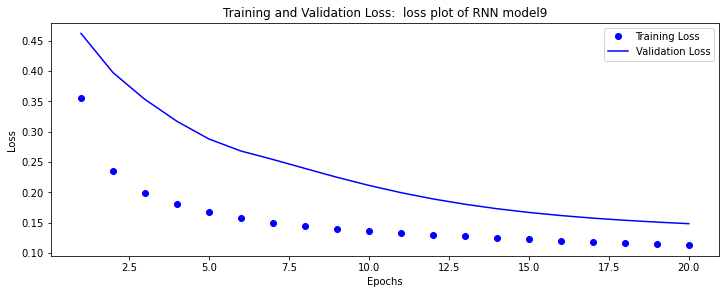

In [15]:
RNN_model9 = models.Sequential()
RNN_model9.add(layers.SimpleRNN(32, return_sequences=True, input_shape=(shape_1, shape_2)))

RNN_model9.add(layers.SimpleRNN(16))


RNN_model9.add(layers.Dense(1))

RNN_model9.compile(optimizer=RMSprop(), loss='mse')
RNN_model9_history = RNN_model9.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(RNN_model9_history, "loss plot of RNN model9")

Epoch 1/20
13/13 [==============================] - 4s 169ms/step - loss: 0.6011 - val_loss: 0.7582
Epoch 2/20
13/13 [==============================] - 2s 142ms/step - loss: 0.4022 - val_loss: 0.5959
Epoch 3/20
13/13 [==============================] - 2s 142ms/step - loss: 0.3660 - val_loss: 0.5165
Epoch 4/20
13/13 [==============================] - 2s 135ms/step - loss: 0.3146 - val_loss: 0.4010
Epoch 5/20
13/13 [==============================] - 2s 155ms/step - loss: 0.2529 - val_loss: 0.4173
Epoch 6/20
13/13 [==============================] - 2s 148ms/step - loss: 0.2672 - val_loss: 0.3971
Epoch 7/20
13/13 [==============================] - 2s 138ms/step - loss: 0.2621 - val_loss: 0.3526
Epoch 8/20
13/13 [==============================] - 2s 148ms/step - loss: 0.2219 - val_loss: 0.3478
Epoch 9/20
13/13 [==============================] - 2s 143ms/step - loss: 0.2364 - val_loss: 0.2988
Epoch 10/20
13/13 [==============================] - 2s 145ms/step - loss: 0.2224 - val_loss: 0.2875

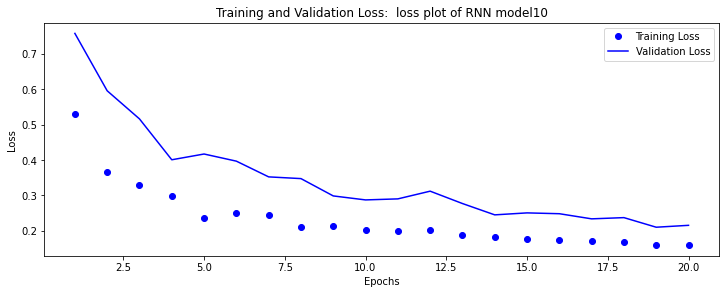

In [16]:
RNN_model10 = models.Sequential()
RNN_model10.add(layers.SimpleRNN(32, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

RNN_model10.add(layers.SimpleRNN(16))

RNN_model10.add(layers.Dense(1))

RNN_model10.compile(optimizer=RMSprop(), loss='mse')
RNN_model10_history = RNN_model10.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(RNN_model10_history, "loss plot of RNN model10")

Epoch 1/40
13/13 [==============================] - 3s 161ms/step - loss: 0.4124 - val_loss: 0.3780
Epoch 2/40
13/13 [==============================] - 2s 133ms/step - loss: 0.3305 - val_loss: 0.4015
Epoch 3/40
13/13 [==============================] - 2s 142ms/step - loss: 0.2702 - val_loss: 0.4026
Epoch 4/40
13/13 [==============================] - 2s 148ms/step - loss: 0.2483 - val_loss: 0.4088
Epoch 5/40
13/13 [==============================] - 2s 141ms/step - loss: 0.2437 - val_loss: 0.3960
Epoch 6/40
13/13 [==============================] - 2s 143ms/step - loss: 0.2419 - val_loss: 0.3864
Epoch 7/40
13/13 [==============================] - 2s 136ms/step - loss: 0.2378 - val_loss: 0.3743
Epoch 8/40
13/13 [==============================] - 2s 142ms/step - loss: 0.2099 - val_loss: 0.3664
Epoch 9/40
13/13 [==============================] - 2s 149ms/step - loss: 0.1933 - val_loss: 0.3477
Epoch 10/40
13/13 [==============================] - 2s 143ms/step - loss: 0.2018 - val_loss: 0.3344

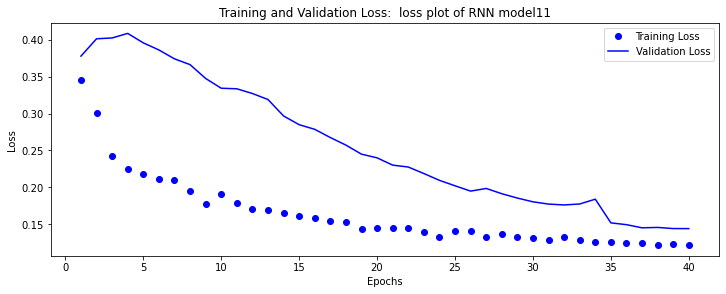

In [17]:
RNN_model11 = models.Sequential()
RNN_model11.add(layers.SimpleRNN(10, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

RNN_model11.add(layers.SimpleRNN(5))


RNN_model11.add(layers.Dense(1))

RNN_model11.compile(optimizer=RMSprop(), loss='mse')
RNN_model11_history = RNN_model11.fit(train_dataset, epochs=40, validation_data=val_dataset)

plot_simple_loss(RNN_model11_history, "loss plot of RNN model11")

Epoch 1/30
13/13 [==============================] - 7s 314ms/step - loss: 0.6534 - val_loss: 1.9444
Epoch 2/30
13/13 [==============================] - 3s 226ms/step - loss: 0.3670 - val_loss: 1.4486
Epoch 3/30
13/13 [==============================] - 3s 273ms/step - loss: 0.3120 - val_loss: 1.2018
Epoch 4/30
13/13 [==============================] - 3s 228ms/step - loss: 0.2792 - val_loss: 1.1977
Epoch 5/30
13/13 [==============================] - 3s 227ms/step - loss: 0.2688 - val_loss: 1.2206
Epoch 6/30
13/13 [==============================] - 3s 225ms/step - loss: 0.2507 - val_loss: 1.0536
Epoch 7/30
13/13 [==============================] - 3s 252ms/step - loss: 0.2533 - val_loss: 1.0368
Epoch 8/30
13/13 [==============================] - 3s 226ms/step - loss: 0.2407 - val_loss: 1.0841
Epoch 9/30
13/13 [==============================] - 3s 219ms/step - loss: 0.2290 - val_loss: 0.9716
Epoch 10/30
13/13 [==============================] - 3s 265ms/step - loss: 0.2091 - val_loss: 0.9911

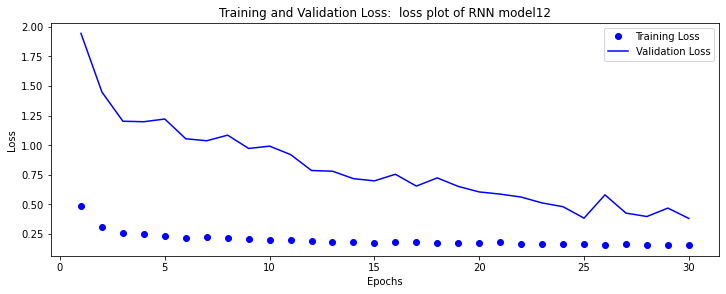

In [18]:
RNN_model12 = models.Sequential()
RNN_model12.add(layers.SimpleRNN(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

RNN_model12.add(layers.SimpleRNN(50, return_sequences=True,dropout=0.2, recurrent_dropout=0.2))

RNN_model12.add(layers.SimpleRNN(50))


RNN_model12.add(layers.Dense(1))

RNN_model12.compile(optimizer=RMSprop(), loss='mse')
RNN_model12_history = RNN_model12.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(RNN_model12_history, "loss plot of RNN model12")

Epoch 1/30
13/13 [==============================] - 8s 358ms/step - loss: 1.1785 - val_loss: 2.7238
Epoch 2/30
13/13 [==============================] - 4s 274ms/step - loss: 0.5289 - val_loss: 2.0779
Epoch 3/30
13/13 [==============================] - 4s 336ms/step - loss: 0.3984 - val_loss: 1.8723
Epoch 4/30
13/13 [==============================] - 4s 325ms/step - loss: 0.3320 - val_loss: 1.4784
Epoch 5/30
13/13 [==============================] - 4s 284ms/step - loss: 0.3030 - val_loss: 1.7781
Epoch 6/30
13/13 [==============================] - 4s 349ms/step - loss: 0.2979 - val_loss: 1.5385
Epoch 7/30
13/13 [==============================] - 4s 282ms/step - loss: 0.2808 - val_loss: 1.6862
Epoch 8/30
13/13 [==============================] - 4s 283ms/step - loss: 0.2764 - val_loss: 1.4405
Epoch 9/30
13/13 [==============================] - 4s 285ms/step - loss: 0.2708 - val_loss: 1.5625
Epoch 10/30
13/13 [==============================] - 4s 281ms/step - loss: 0.2708 - val_loss: 1.4169

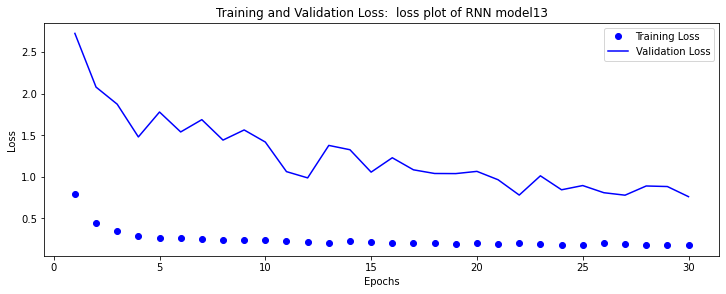

In [19]:
RNN_model13 = models.Sequential()
RNN_model13.add(layers.SimpleRNN(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

RNN_model13.add(layers.SimpleRNN(50, return_sequences=True,dropout=0.2, recurrent_dropout=0.2))
RNN_model13.add(layers.SimpleRNN(50, return_sequences=True,dropout=0.2, recurrent_dropout=0.2))
RNN_model13.add(layers.SimpleRNN(50))


RNN_model13.add(layers.Dense(1))

RNN_model13.compile(optimizer=RMSprop(), loss='mse')
RNN_model13_history = RNN_model13.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(RNN_model13_history, "loss plot of RNN model13")

Epoch 1/20
13/13 [==============================] - 4s 178ms/step - loss: 0.5818 - val_loss: 0.6035
Epoch 2/20
13/13 [==============================] - 2s 143ms/step - loss: 0.2317 - val_loss: 0.4817
Epoch 3/20
13/13 [==============================] - 2s 135ms/step - loss: 0.1954 - val_loss: 0.4036
Epoch 4/20
13/13 [==============================] - 2s 143ms/step - loss: 0.1742 - val_loss: 0.3459
Epoch 5/20
13/13 [==============================] - 2s 134ms/step - loss: 0.1596 - val_loss: 0.2991
Epoch 6/20
13/13 [==============================] - 2s 136ms/step - loss: 0.1486 - val_loss: 0.2701
Epoch 7/20
13/13 [==============================] - 2s 142ms/step - loss: 0.1403 - val_loss: 0.2552
Epoch 8/20
13/13 [==============================] - 2s 141ms/step - loss: 0.1325 - val_loss: 0.2481
Epoch 9/20
13/13 [==============================] - 3s 219ms/step - loss: 0.1259 - val_loss: 0.2445
Epoch 10/20
13/13 [==============================] - 2s 146ms/step - loss: 0.1206 - val_loss: 0.2429

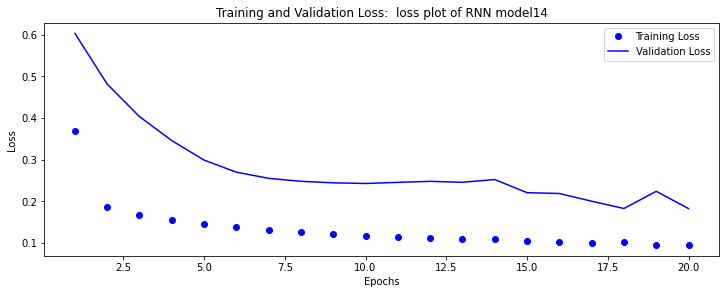

In [20]:
RNN_model14 = models.Sequential()
RNN_model14.add(layers.SimpleRNN(64, return_sequences=True, input_shape=(shape_1, shape_2)))

RNN_model14.add(layers.SimpleRNN(32))

RNN_model14.add(layers.Dense(1))

RNN_model14.compile(optimizer=RMSprop(), loss='mse')
RNN_model14_history = RNN_model14.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(RNN_model14_history, "loss plot of RNN model14")

Epoch 1/20
13/13 [==============================] - 3s 159ms/step - loss: 1.1696 - val_loss: 0.3799
Epoch 2/20
13/13 [==============================] - 2s 184ms/step - loss: 0.3388 - val_loss: 0.3872
Epoch 3/20
13/13 [==============================] - 2s 116ms/step - loss: 0.2324 - val_loss: 0.3889
Epoch 4/20
13/13 [==============================] - 2s 147ms/step - loss: 0.1917 - val_loss: 0.3763
Epoch 5/20
13/13 [==============================] - 2s 132ms/step - loss: 0.1734 - val_loss: 0.3563
Epoch 6/20
13/13 [==============================] - 2s 130ms/step - loss: 0.1626 - val_loss: 0.3340
Epoch 7/20
13/13 [==============================] - 2s 132ms/step - loss: 0.1606 - val_loss: 0.3234
Epoch 8/20
13/13 [==============================] - 2s 128ms/step - loss: 0.1574 - val_loss: 0.2901
Epoch 9/20
13/13 [==============================] - 2s 131ms/step - loss: 0.1523 - val_loss: 0.2830
Epoch 10/20
13/13 [==============================] - 2s 128ms/step - loss: 0.1480 - val_loss: 0.2632

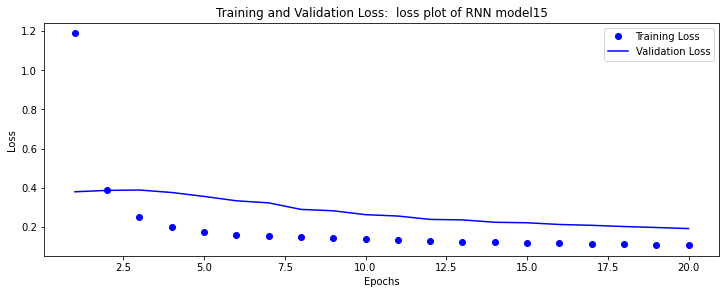

In [21]:
RNN_model15 = models.Sequential()
RNN_model15.add(layers.SimpleRNN(16, return_sequences=True, input_shape=(shape_1, shape_2)))

RNN_model15.add(layers.SimpleRNN(16))

RNN_model15.add(layers.Dense(1))

RNN_model15.compile(optimizer=RMSprop(), loss='mse')
RNN_model15_history = RNN_model15.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(RNN_model15_history, "loss plot of RNN model15")

Epoch 1/20
13/13 [==============================] - 3s 170ms/step - loss: 0.6848 - val_loss: 0.8444
Epoch 2/20
13/13 [==============================] - 2s 156ms/step - loss: 0.2606 - val_loss: 0.7613
Epoch 3/20
13/13 [==============================] - 2s 151ms/step - loss: 0.2345 - val_loss: 0.5925
Epoch 4/20
13/13 [==============================] - 2s 154ms/step - loss: 0.2005 - val_loss: 0.4606
Epoch 5/20
13/13 [==============================] - 2s 144ms/step - loss: 0.1778 - val_loss: 0.3860
Epoch 6/20
13/13 [==============================] - 2s 157ms/step - loss: 0.1648 - val_loss: 0.3481
Epoch 7/20
13/13 [==============================] - 2s 154ms/step - loss: 0.1564 - val_loss: 0.3172
Epoch 8/20
13/13 [==============================] - 2s 145ms/step - loss: 0.1488 - val_loss: 0.2903
Epoch 9/20
13/13 [==============================] - 2s 161ms/step - loss: 0.1439 - val_loss: 0.2670
Epoch 10/20
13/13 [==============================] - 2s 196ms/step - loss: 0.1404 - val_loss: 0.2457

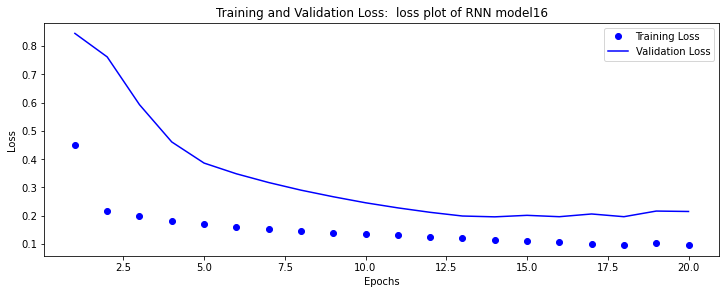

In [22]:
RNN_model16 = models.Sequential()
RNN_model16.add(layers.SimpleRNN(64, return_sequences=True, input_shape=(shape_1, shape_2)))

RNN_model16.add(layers.SimpleRNN(64))

RNN_model16.add(layers.Dense(1))

RNN_model16.compile(optimizer=RMSprop(), loss='mse')
RNN_model16_history = RNN_model16.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(RNN_model16_history, "loss plot of RNN model16")

Epoch 1/20
13/13 [==============================] - 5s 235ms/step - loss: 0.5723 - val_loss: 0.6018
Epoch 2/20
13/13 [==============================] - 2s 190ms/step - loss: 0.2633 - val_loss: 0.7311
Epoch 3/20
13/13 [==============================] - 2s 191ms/step - loss: 0.2351 - val_loss: 0.6232
Epoch 4/20
13/13 [==============================] - 3s 264ms/step - loss: 0.2195 - val_loss: 0.5709
Epoch 5/20
13/13 [==============================] - 3s 197ms/step - loss: 0.2088 - val_loss: 0.5385
Epoch 6/20
13/13 [==============================] - 2s 185ms/step - loss: 0.2009 - val_loss: 0.4953
Epoch 7/20
13/13 [==============================] - 2s 186ms/step - loss: 0.1916 - val_loss: 0.4512
Epoch 8/20
13/13 [==============================] - 3s 239ms/step - loss: 0.1806 - val_loss: 0.4277
Epoch 9/20
13/13 [==============================] - 4s 280ms/step - loss: 0.1698 - val_loss: 0.4252
Epoch 10/20
13/13 [==============================] - 3s 205ms/step - loss: 0.1623 - val_loss: 0.4223

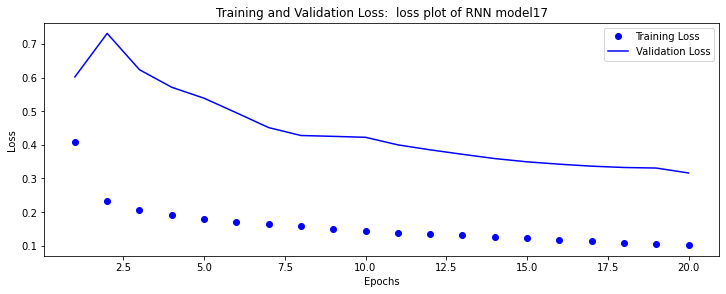

In [23]:
RNN_model17 = models.Sequential()
RNN_model17.add(layers.SimpleRNN(32, return_sequences=True, input_shape=(shape_1, shape_2)))

RNN_model17.add(layers.SimpleRNN(32, return_sequences=True))
RNN_model17.add(layers.SimpleRNN(32, return_sequences=True))
RNN_model17.add(layers.SimpleRNN(32))
RNN_model17.add(layers.Dense(1))

RNN_model17.compile(optimizer=RMSprop(), loss='mse')
RNN_model17_history = RNN_model17.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(RNN_model17_history, "loss plot of RNN model17")

Epoch 1/20
13/13 [==============================] - 6s 283ms/step - loss: 1.0054 - val_loss: 0.7442
Epoch 2/20
13/13 [==============================] - 2s 155ms/step - loss: 0.2787 - val_loss: 0.7896
Epoch 3/20
13/13 [==============================] - 2s 160ms/step - loss: 0.2412 - val_loss: 0.7144
Epoch 4/20
13/13 [==============================] - 2s 163ms/step - loss: 0.2046 - val_loss: 0.6198
Epoch 5/20
13/13 [==============================] - 2s 191ms/step - loss: 0.1794 - val_loss: 0.5559
Epoch 6/20
13/13 [==============================] - 2s 189ms/step - loss: 0.1652 - val_loss: 0.5270
Epoch 7/20
13/13 [==============================] - 2s 157ms/step - loss: 0.1544 - val_loss: 0.4941
Epoch 8/20
13/13 [==============================] - 3s 211ms/step - loss: 0.1444 - val_loss: 0.4743
Epoch 9/20
13/13 [==============================] - 2s 162ms/step - loss: 0.1371 - val_loss: 0.4714
Epoch 10/20
13/13 [==============================] - 2s 156ms/step - loss: 0.1317 - val_loss: 0.4656

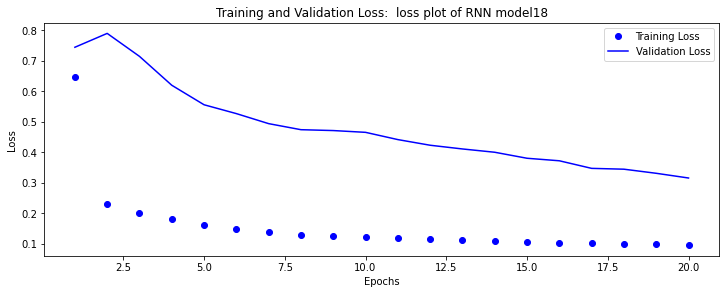

In [24]:
RNN_model18 = models.Sequential()
RNN_model18.add(layers.SimpleRNN(32, return_sequences=True, input_shape=(shape_1, shape_2)))

RNN_model18.add(layers.SimpleRNN(32, return_sequences=True))
RNN_model18.add(layers.SimpleRNN(32))

RNN_model18.add(layers.Dense(1))

RNN_model18.compile(optimizer=RMSprop(), loss='mse')
RNN_model18_history = RNN_model18.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(RNN_model18_history, "loss plot of RNN model18")